## TensorFlow

In [42]:
import tensorflow as tf
import pandas as pd

from keras.losses import mean_squared_error

# 直接运行加载数据集
df = pd.read_csv("course-12-data.csv", header=0)
df.head()  # 预览前 5 行数据

tf.get_logger().setLevel("ERROR")

# 将数组转换为常量张量
X = tf.cast(tf.constant(df[["X0", "X1"]].values), tf.float32)
y = tf.constant(df[["Y"]].values)

X.shape, y.shape

class Model(object):
    def __init__(self):
        # 初始化权重全为 1，也可以随机初始化
        # 选择变量张量，因为权重后续会不断迭代更新
        self.W1 = tf.Variable(tf.ones([2, 3]))
        self.W2 = tf.Variable(tf.ones([3, 1]))

    def __call__(self, x):
        hidden_layer = tf.nn.sigmoid(tf.linalg.matmul(x, self.W1))  # 隐含层前向传播
        y_ = tf.nn.sigmoid(tf.linalg.matmul(hidden_layer, self.W2))  # 输出层前向传播
        return y_

def loss_fn(model, X, y):
    y_ = model(X)  # 前向传播得到预测值
    # 使用 MSE 损失函数，并使用 reduce_mean 计算样本总损失
    loss = tf.reduce_mean(mean_squared_error(y_true=y, y_pred=y_))
    return loss

model = Model()  # 实例化类
y_ = model(X)  # 测试输入
loss = loss_fn(model, X, y)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.2723010778427124>

In [43]:
EPOCHS = 200  # 迭代 200 次
LEARNING_RATE = 0.1  # 学习率
# 定义 SGD 优化器，设定学习率，
optimizer = tf.optimizers.SGD(learning_rate=0.1)
optimizer

loss_list = []  # 存放每一次 loss
model = Model()  # 实例化类
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, X, y)  # 计算 Loss，包含前向传播过程
        loss_list.append(loss)  # 保存每次迭代 loss

    grads = tape.gradient(loss, [model.W1, model.W2])  # 输出自动微分结果
    optimizer.apply_gradients(zip(grads, [model.W1, model.W2]))  # 使用优化器更新梯度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f"Epoch [000/{EPOCHS}], Loss: [{loss:.4f}]")
    elif (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: [{loss:.4f}]")

Epoch [000/200], Loss: [1.2723]
Epoch [100/200], Loss: [0.9051]
Epoch [200/200], Loss: [0.8889]


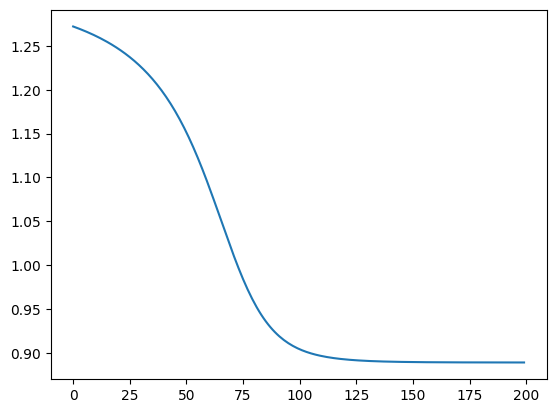

In [44]:
from matplotlib import pyplot as plt

plt.plot(loss_list)  # 绘制 loss 变化图像

## DIGITS 分类

In [45]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()  # 读取数据

digits_X = digits.data  # 特征值
digits_y = digits.target  # 标签值

digits_X.shape, digits_y.shape

digits_y.reshape(-1).shape

(1797,)

In [46]:
digits_y = np.eye(10)[digits_y.reshape(-1)]
digits_y.shape

(1797, 10)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    digits_X, digits_y, test_size=0.2, random_state=1
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437, 10), (360, 10))

In [48]:
import tensorflow as tf


class Model(object):
    def __init__(self):
        # 随机初始化张量参数
        self.W1 = tf.Variable(tf.random.normal([64, 30]))
        self.b1 = tf.Variable(tf.random.normal([30]))
        self.W2 = tf.Variable(tf.random.normal([30, 10]))
        self.b2 = tf.Variable(tf.random.normal([10]))

    def __call__(self, x):
        x = tf.cast(x, tf.float32)  # 转换输入数据类型
        # 线性计算 + RELU 激活
        fc1 = tf.nn.relu(tf.add(tf.matmul(x, self.W1), self.b1))  # 全连接层 1
        fc2 = tf.add(tf.matmul(fc1, self.W2), self.b2)  # 全连接层 2
        return fc2

In [49]:
def softmax(x):
    # Softmax 实现
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)


def loss_fn(model, x, y):
    preds = model(x)
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=y)
    )

def accuracy_fn(logits, labels):
    preds = tf.argmax(logits, axis=1)  # 取值最大的索引，正好对应字符标签
    labels = tf.argmax(labels, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
np.round(softmax([-1.3, 2.6, -0.9]), 2)

array([0.02, 0.95, 0.03])

In [50]:
EPOCHS = 500  # 迭代此时
LEARNING_RATE = 0.02  # 学习率
model = Model()  # 实例化模型类
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:  # 追踪梯度
        loss = loss_fn(model, X_train, y_train)

    trainable_variables = [model.W1, model.b1, model.W2, model.b2]  # 需优化参数列表
    grads = tape.gradient(loss, trainable_variables)  # 计算梯度

    optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)  # Adam 优化器
    optimizer.apply_gradients(zip(grads, trainable_variables))  # 更新梯度

    accuracy = accuracy_fn(model(X_test), y_test)  # 计算准确度

    # 每 100 个 Epoch 输出各项指标
    if epoch == 0:
        print(f"Epoch [000/{EPOCHS}], Accuracy: [{accuracy:.2f}], Loss: [{loss:.4f}]")
    elif (epoch + 1) % 100 == 0:
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], Accuracy: [{accuracy:.2f}], Loss: [{loss:.4f}]"
        )

Epoch [000/500], Accuracy: [0.04], Loss: [380.4020]
Epoch [100/500], Accuracy: [0.89], Loss: [2.9798]
Epoch [200/500], Accuracy: [0.91], Loss: [1.2084]
Epoch [300/500], Accuracy: [0.91], Loss: [0.6689]
Epoch [400/500], Accuracy: [0.93], Loss: [0.3868]
Epoch [500/500], Accuracy: [0.93], Loss: [0.2065]


In [54]:
import pandas as pd

# 加载数据集
df = pd.read_csv("car.data", header=None)
# 设置列名
df.columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [55]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]  # 特征值
y = df["class"]  # 目标

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)    

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1382, 6), (346, 6), (1382,), (346,))

In [56]:
# 将分类变量转换为独热编码
X_train = pd.get_dummies(X_train).values
X_test = pd.get_dummies(X_test).values
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((1382, 21), (346, 21), (1382, 4), (346, 4))